<h2 style='color:blue'>DGX Benchmarking: Small Image Classification Using Simple Aritifical Neural Network</h2>

This notebook shows DGX station benchmarking for small image classification (50k images). DGX station has followng hardware resources,

1) AMD 64 core CPU: 512 GB system memory

2) 4 A100 Tensorcore GPUs: 320 GB total memory

In [32]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [33]:
tf.test.is_built_with_cuda()

True

In [34]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [5]:
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 3.8 MB/s eta 0:00:01


In [35]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

<h4 style="color:purple">Load the dataset</h4>

Our dataset contains 60000 small training images that belongs to one of the below 10 classes

<img src="small_images.jpg" />

In [7]:
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 32s 0us/step


In [8]:
X_train.shape

(50000, 32, 32, 3)

In [9]:
y_train.shape

(50000, 1)

<h4 style="color:purple">Data Visualization</h4>

In [10]:
def plot_sample(index):
    plt.figure(figsize = (10,1))
    plt.imshow(X_train[index])

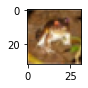

In [11]:
plot_sample(0)

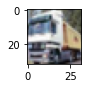

In [12]:
plot_sample(1)

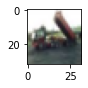

In [13]:
plot_sample(2)

In [14]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

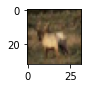

In [15]:
plot_sample(3)

In [16]:
classes[y_train[3][0]]

'deer'

In [17]:
y_train[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

In [18]:
y_test.shape

(10000, 1)

In [19]:
X_train.shape

(50000, 32, 32, 3)

<h4 style="color:purple">Preprocessing: Scale images</h4>

In [20]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [21]:
y_train_categorical = keras.utils.to_categorical(
    y_train, num_classes=10, dtype='float32'
)
y_test_categorical = keras.utils.to_categorical(
    y_test, num_classes=10, dtype='float32'
)

In [22]:
y_train[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [23]:
y_train_categorical[0:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

<h4 style="color:purple">Model building and training</h4>

In [24]:
model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(3000, activation='relu'),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dense(10, activation='sigmoid')    
    ])

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train_categorical, epochs=1)

1563/1563 [==============================] - 3s 1ms/step - loss: 1.9279 - accuracy: 0.3019


<h4 style="color:purple">Let's make some predictions</h4>

In [25]:
np.argmax(model.predict(X_test_scaled)[0])

3

In [26]:
y_test[0]

array([3], dtype=uint8)

In [27]:
def get_model():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(32,32,3)),
            keras.layers.Dense(3000, activation='relu'),
            keras.layers.Dense(1000, activation='relu'),
            keras.layers.Dense(10, activation='sigmoid')    
        ])

    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

<h3 style='color:purple'>Measure training time on a CPU on DGX station<h3>

In [28]:
%%timeit -n1 -r1 
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

1563/1563 [==============================] - 23s 14ms/step - loss: 1.9322 - accuracy: 0.3041
23.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<h3 style='color:purple'>Lets measure training time using default configuration i.e. GPU + CPU on DGX station<h3>

In [37]:
%%timeit -n1 -r1 
gpu_model = get_model()
gpu_model.fit(X_train_scaled, y_train_categorical, epochs=1)

1563/1563 [==============================] - 2s 1ms/step - loss: 1.9305 - accuracy: 0.3030
2.81 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


All right it, for CPU it took 23.2 seconds and for GPU it was around 2.81 sec. That is almost **8 times faster** on same DGX station (comparing the performance of only CPU vs GPU)

<h3 style='color:purple'>Lets run same test for 10 epocs using DGX GPU+CPU<h3>

In [30]:
%%timeit -n1 -r1 
gpu_model = get_model()
gpu_model.fit(X_train_scaled, y_train_categorical, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.9318 - accuracy: 0.3019
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.6434 - accuracy: 0.4190
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.5542 - accuracy: 0.4516
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4832 - accuracy: 0.4823
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.4275 - accuracy: 0.4998
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.3886 - accuracy: 0.5099
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.3601 - accuracy: 0.5212
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.3204 - accuracy: 0.5366
Epoch 9/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.2795 - accuracy: 0.5484
Epoch 10/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.249

<h3 style='color:purple'>Now compare DGX station with my regular deep learning PC<h3>

I ran above same exact tests on my regular PC. My PC has NVIDIA Titan RTX GPU, there I first ran these tests without using titan RTX and with titan RTX and now I am comparing those tests with DGX station and below table

Notebook containing benchmarks on my regular PC (scroll to the bottom): https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/10_gpu_benchmarking/gpu_performance_test_small_image_classification.ipynb

Here is the performance comparison for regular PC vs DGX,

| Epoch | Regular PC without GPU | Regular PC with GPU (Titan RTX) | DGX Station
|:------|:------|:------|:------|
| 1 | 43 sec | 3 sec | 2.81 sec|
| 10 | 7 min 26 sec | 30 sec | 20 sec |

You can see that DGX station is **22 times faster** when I compare time for 10 epochs for regular PC without GPU. As the dataset size and number of epochs grows, time for training will significantly reduce even further on DGX station as we will be utilizing the enormous GPU computer power for training workload.